# This notebook is intended to be run on Google colab

In [1]:
import math
import os
import zipfile
from shutil import copyfile

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from IPython.display import display
from PIL import Image, ImageDraw
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Exercise 1

In [2]:
# Select GPU under Edit -> Notebook settings. Using a TPU will require further modifications

# Check if GPU is present
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


#### Download and pre-process data set

In [3]:
# NB: The data is available at https://www.kaggle.com/c/dog-breed-identification/data(permanent, requires an account) 
# or https://www.dropbox.com/s/l7b7l5fjwwj6ad2/dog-breed-identification.zip?dl=0 (temporary, no login needed
# Download the file and extract it in a directory called data/ next to this notebook

if not os.path.isdir('data'):
    os.mkdir('data')

!wget -O dog-breed-identification.zip https://www.dropbox.com/s/l7b7l5fjwwj6ad2/dog-breed-identification.zip?dl=0

--2021-01-21 15:04:11--  https://www.dropbox.com/s/l7b7l5fjwwj6ad2/dog-breed-identification.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/l7b7l5fjwwj6ad2/dog-breed-identification.zip [following]
--2021-01-21 15:04:11--  https://www.dropbox.com/s/raw/l7b7l5fjwwj6ad2/dog-breed-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc01ee88a92f9d00b8cc59abe614.dl.dropboxusercontent.com/cd/0/inline/BHZE4x9LpG2WHgqSGwTfkaSfBzi0ZUqM2d4uAB_5d_6609cQXCwDli2-KSJnotmZOvb7fvD9WKKInLjO5l6-kYrYHAdE-tAdDr4FdoDXzDjdB5AVtUMYxKadHM1dZoK2Mp4/file# [following]
--2021-01-21 15:04:12--  https://uc01ee88a92f9d00b8cc59abe614.dl.dropboxusercontent.com/cd/0/inline/BHZE4x9LpG2WHgqSGwTfkaSfBzi0ZUqM2d4uAB_5d_6609cQXCwDli2-KS

In [4]:
with zipfile.ZipFile("dog-breed-identification.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [5]:
data = pd.read_csv("data/labels.csv")

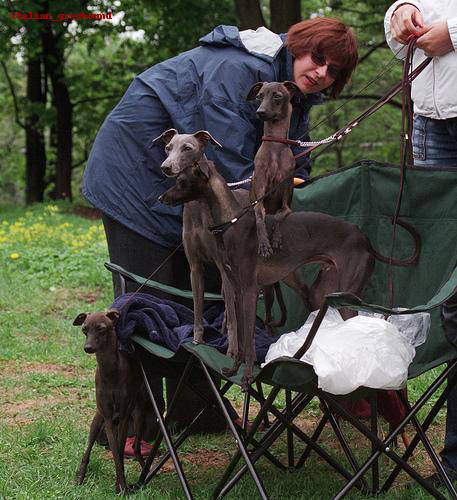

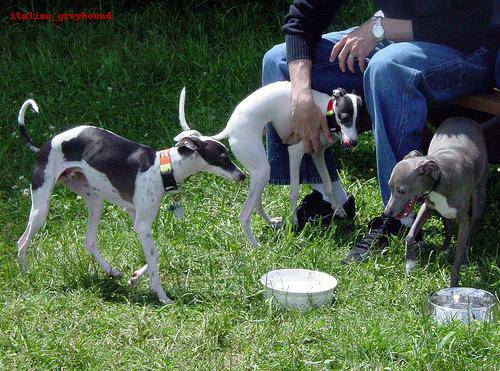

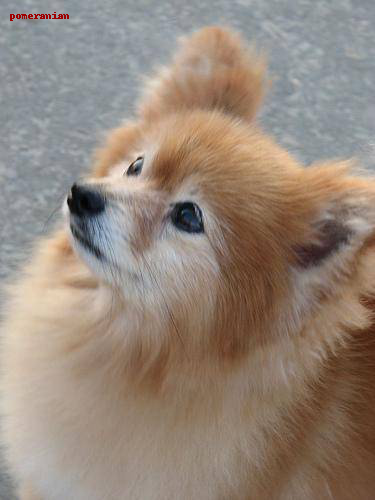

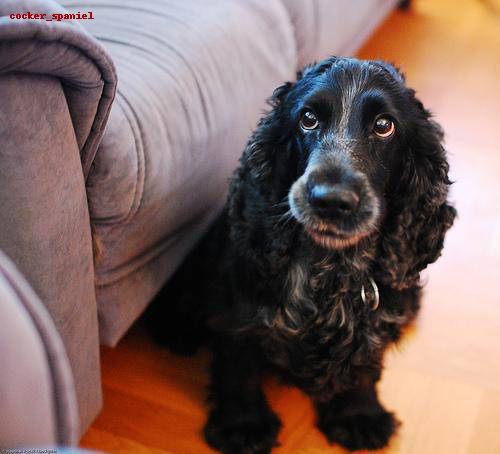

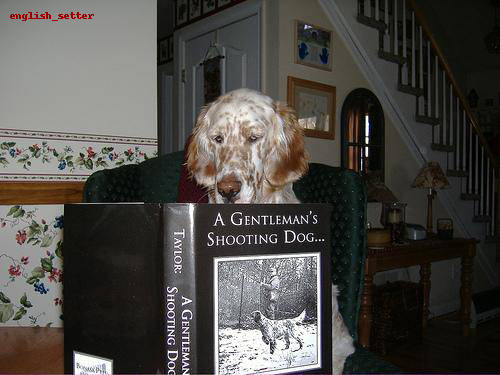

In [6]:
for index, row in data.sample(5).iterrows():
    image = Image.open(f"data/train/{row.id}.jpg")
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), row.breed, fill="#a00000")
    display(image)

In [7]:
if not os.path.isdir("data/train_sorted"):
    os.mkdir("data/train_sorted")
if not os.path.isdir("data/val_sorted"):
    os.mkdir("data/val_sorted")

In [8]:
breeds = set(data.breed)
for dog in breeds:
    os.mkdir(f"data/train_sorted/{dog}")
    os.mkdir(f"data/val_sorted/{dog}")
    ids = data[data.breed == dog].id
    split = math.ceil(len(ids.index) / 5)
    for image_id in ids[:split]:
        src = f"data/train/{image_id}.jpg"
        dst = f"data/val_sorted/{dog}/{image_id}.jpg"
        copyfile(src, dst)
    for image_id in ids[split:]:
        src = f"data/train/{image_id}.jpg"
        dst = f"data/train_sorted/{dog}/{image_id}.jpg"
        copyfile(src, dst)

#### Define data generators

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    horizontal_flip=True,
    rotation_range=30,
    brightness_range=(0.5, 1.5),
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode="reflect",
)
train_generator = train_datagen.flow_from_directory(
    directory="data/train_sorted",
    class_mode="categorical",
    batch_size=32,
    target_size=(224, 224),
    shuffle=True,
)

Found 8127 images belonging to 120 classes.


In [10]:
val_datagen = ImageDataGenerator(rescale=1 / 255)
validation_generator = val_datagen.flow_from_directory(
    directory="data/val_sorted",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
)

Found 2095 images belonging to 120 classes.


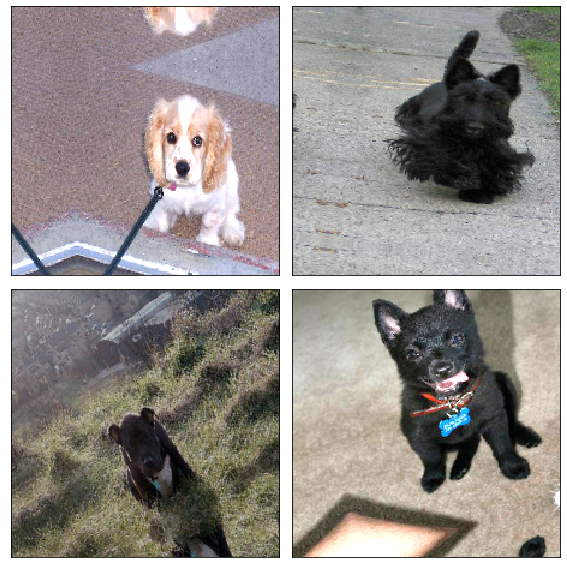

In [11]:
sample_images = next(train_generator)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(
        sample_images[0][i,],
        interpolation="nearest",
        aspect="equal",
    )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

#### Define and compile model

In [12]:
model = keras.Sequential(
    [
        # Block 1
        layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu",input_shape=(224, 224, 3)),
        layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

        # Block 2
        layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

        # Block 3
        layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

        # Block 4
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

        # Flatten by global averaging
        layers.GlobalAvgPool2D(),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),

        # Output for 120 Classes
        layers.Dense(120, activation="softmax")
    ]
)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

#### Train model

In [13]:
steps_per_epoch = math.floor(train_generator.n / 32)
validation_steps = math.floor(validation_generator.n / 32)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # Reduced from 100 to 5
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=True,
)

Epoch 1/5
253/253 [==============================] - 166s 615ms/step - loss: 4.7875 - accuracy: 0.0106 - val_loss: 4.7807 - val_accuracy: 0.0096
Epoch 2/5
253/253 [==============================] - 152s 601ms/step - loss: 4.7820 - accuracy: 0.0111 - val_loss: 4.7774 - val_accuracy: 0.0125
Epoch 3/5
253/253 [==============================] - 152s 602ms/step - loss: 4.7782 - accuracy: 0.0116 - val_loss: 4.7775 - val_accuracy: 0.0125
Epoch 4/5
253/253 [==============================] - 152s 600ms/step - loss: 4.7807 - accuracy: 0.0112 - val_loss: 4.7764 - val_accuracy: 0.0125
Epoch 5/5
253/253 [==============================] - 152s 601ms/step - loss: 4.7756 - accuracy: 0.0147 - val_loss: 4.7772 - val_accuracy: 0.0125


In [14]:
model.save("custom_cnn_lab8")

INFO:tensorflow:Assets written to: custom_cnn_lab8/assets


#### Plot training metrics

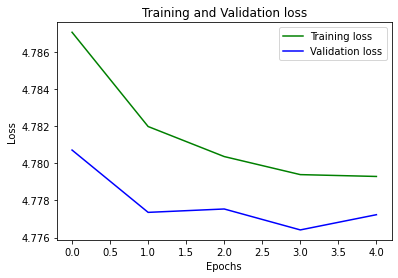

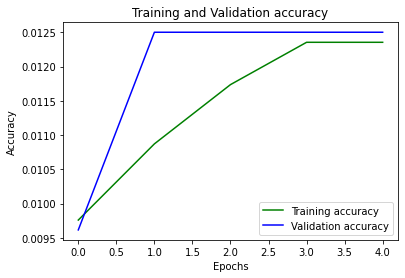

In [15]:
def plot_model(tf_history):
    loss_train = tf_history.history["loss"]
    loss_val = tf_history.history["val_loss"]
    plt.plot(loss_train, "g", label="Training loss")
    plt.plot(loss_val, "b", label="Validation loss")
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    loss_train = tf_history.history["accuracy"]
    loss_val = tf_history.history["val_accuracy"]
    plt.plot(loss_train, "g", label="Training accuracy")
    plt.plot(loss_val, "b", label="Validation accuracy")
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


plot_model(history)

#### Download pre-trained model

In [16]:
vgg_headless = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step


#### Define custom head

In [17]:
vgg_head = vgg_headless.output

In [18]:
vgg_head = layers.GlobalAveragePooling2D()(vgg_head)
vgg_head = layers.Dense(512, activation="relu")(vgg_head)
vgg_head = layers.Dense(512, activation="relu")(vgg_head)
vgg_head = layers.Dense(120, activation="softmax")(vgg_head)

vgg_pretrained = Model(inputs=vgg_headless.input, outputs=vgg_head)

#### Freeze layers of pre-trained model

In [19]:
for layer in vgg_pretrained.layers[:19]:
    layer.trainable = False

In [20]:
vgg_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Compile and train

In [21]:
vgg_pretrained.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [22]:
history_pretrained = vgg_pretrained.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=True,
)

Epoch 1/10
253/253 [==============================] - 137s 539ms/step - loss: 4.7906 - accuracy: 0.0102 - val_loss: 4.4851 - val_accuracy: 0.0284
Epoch 2/10
253/253 [==============================] - 137s 541ms/step - loss: 4.4707 - accuracy: 0.0264 - val_loss: 4.1507 - val_accuracy: 0.0683
Epoch 3/10
253/253 [==============================] - 137s 540ms/step - loss: 4.1528 - accuracy: 0.0581 - val_loss: 3.8231 - val_accuracy: 0.0947
Epoch 4/10
253/253 [==============================] - 137s 543ms/step - loss: 3.8958 - accuracy: 0.0924 - val_loss: 3.5943 - val_accuracy: 0.1442
Epoch 5/10
253/253 [==============================] - 138s 544ms/step - loss: 3.7320 - accuracy: 0.1151 - val_loss: 3.4054 - val_accuracy: 0.1596
Epoch 6/10
253/253 [==============================] - 137s 541ms/step - loss: 3.5717 - accuracy: 0.1438 - val_loss: 3.3143 - val_accuracy: 0.1668
Epoch 7/10
253/253 [==============================] - 138s 544ms/step - loss: 3.4893 - accuracy: 0.1649 - val_loss: 3.3121 -

In [23]:
vgg_pretrained.save("vgg_pretrained")

INFO:tensorflow:Assets written to: vgg_pretrained/assets


#### Plot training metrics

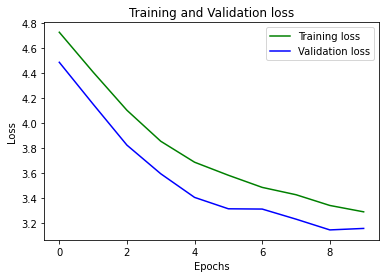

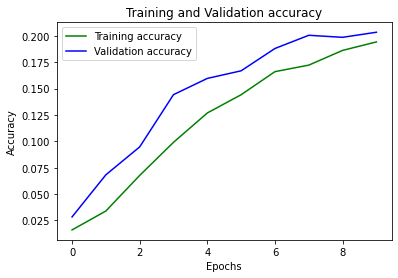

In [24]:
plot_model(history_pretrained)

## Exercise 2

In [25]:
import functools

In [26]:
strides = (1,1,2, 1,1,2, 1,1,1,2, 1,1,1,2, 1,1,1,2)
kernels = (3,3,2, 3,3,2, 3,3,3,2, 3,3,3,2, 3,3,3,2)

In [27]:
def receptive_field_recursion(l, r):
    return strides[r] * l + kernels[r] - strides[r]


functools.reduce(receptive_field_recursion, reversed(range(len(strides))), 1)

212